Mean Absolute Percentage Error (MAPE) für das RF Modell: 11.70%
Bias des Modells: -263.62


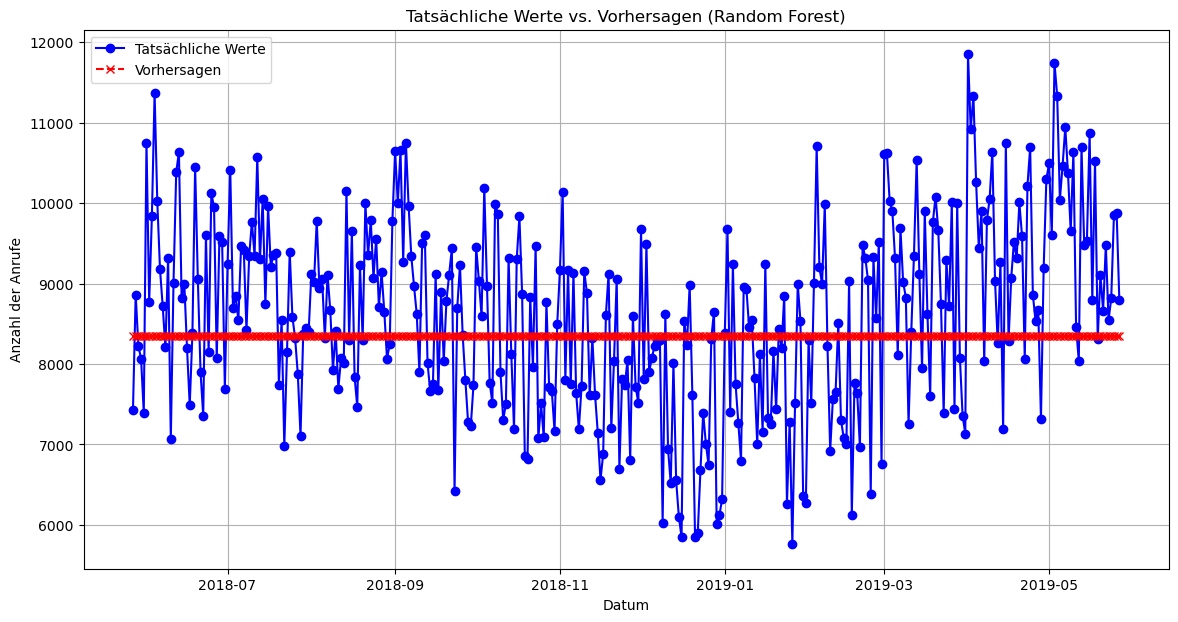

In [214]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])

    def _predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(set(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        if best_feature is None:
            return Node(value=self._most_common_label(y))

        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _split(self, X_column, split_threshold):
        left_idxs = np.where(X_column <= split_threshold)[0]
        right_idxs = np.where(X_column > split_threshold)[0]
        return left_idxs, right_idxs

    def _best_split(self, X, y, feat_idxs):
        best_feature, best_thresh = None, None
        # Code to find the best feature and threshold
        return best_feature, best_thresh

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)
        if most_common:
            return most_common[0][0]
        return None

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class RandomForest:
    def __init__(self, n_trees=100, max_depth=10, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.array([self._most_common_label(preds) for preds in tree_preds.T])

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)
        if most_common:
            return most_common[0][0]
        return None

# Beispiel-Daten laden
train = pd.read_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/train_data.csv')
test = pd.read_csv('/Users/frederic/Desktop/Fallstudie-Model-Engineering/data/processed/test_data.csv')

# Konvertiere die 'date'-Spalte in das DateTime-Format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
prediction_dates = test['date']

# Setze 'date' als Index
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

# Definieren der Features und der Zielvariable
X_train = train[['weekday', 'Feiertage', 'quarter', 'schulferien', 'season', 'month', 'year', 'lag_49_calls', 'lag_365_calls', 'calendarweek', 'rolling_mean_7_calls']]
y_train = train['calls']

X_test = test[['weekday', 'Feiertage', 'quarter', 'schulferien', 'season', 'month', 'year', 'lag_49_calls', 'lag_365_calls', 'calendarweek', 'rolling_mean_7_calls']]
y_test = test['calls']

# Initialisieren und Trainieren des Modells
clf = RandomForest()  # Ersetze dies durch deinen RandomForest-Import
clf.fit(X_train.values, y_train.values)  # Übergib NumPy-Arrays an fit

# Vorhersagen treffen
# Leere Liste zum Speichern der Vorhersagen
predictions = []

# Iteriere über jedes Datum im Testset
for i in range(len(X_test)):
    # Lade die X-Werte für das aktuelle Datum
    X_single = X_test.iloc[i].values.reshape(1, -1)
    
    # Erstelle eine Vorhersage für das aktuelle Datum
    pred = clf.predict(X_single)
    
    # Speichere die Vorhersage
    predictions.append(pred[0])

# MAPE und Bias wie bisher berechnen
mape_RF = np.mean(np.abs((y_test.values - predictions) / y_test.values)) * 100
print(f'Mean Absolute Percentage Error (MAPE) für das RF Modell: {mape_RF:.2f}%')

bias = np.mean(np.array(predictions) - y_test.values)
print(f'Bias des Modells: {bias:.2f}')

# Vorhersagen und tatsächliche Werte visualisieren
plt.figure(figsize=(14, 7))
plt.plot(prediction_dates, y_test.values, label='Tatsächliche Werte', color='blue', marker='o')
plt.plot(prediction_dates, predictions, label='Vorhersagen', color='red', linestyle='--', marker='x')
plt.title('Tatsächliche Werte vs. Vorhersagen (Random Forest)')
plt.xlabel('Datum')
plt.ylabel('Anzahl der Anrufe')
plt.legend()
plt.grid(True)
plt.show()